In [1]:
using Images, Optim, Interpolations
import PyPlot
include("./Common.jl");

###############Helper FUNCTIONS for prior and likelihood########################

function mrf_log_prior(flow::Array{Float64,3}, sigma)

    height,width = size(flow);# first two
#calculating derivative of u and v and using gaussian(penalising the diff(gradient) by squaring)
    # horizontal compatibility
    uh  = flow[:,1:end-1,1] - flow[:,2:end,1];
   
    uph = [log_gauss(uh, sigma) zeros(height,1)];
    

    # vertical compatibility
    uv  = flow[1:end-1,:,1] - flow[2:end,:,1];
    upv = [log_gauss(uv, sigma); zeros(1,width)];
    
    
     # horizontal compatibility
    vh  = flow[:,1:end-1,2] - flow[:,2:end,2];
    vph = [log_gauss(vh, sigma) zeros(height,1)];

    # vertical compatibility
    vv  = flow[1:end-1,:,2] - flow[2:end,:,2];
    vpv = [log_gauss(vv, sigma); zeros(1,width)];

    u=uph + upv
    v=vph + vpv
    return u,v;
end

function grad_mrf_log_prior(flow::Array{Float64,3}, sigma)
    
    height,width = size(flow);# first two

    # horizontal compatibility
    uh  = flow[:,1:end-1,1] - flow[:,2:end,1];
    dph = grad_log_gauss(uh, sigma);
    uph = hcat(dph, zeros(height,1)) - hcat(zeros(height,1), dph);
    
    # vertical compatibility
    uv  = flow[1:end-1,:,1] - flow[2:end,:,1];
    dpv = grad_log_gauss(uv, sigma);
    upv = vcat(dpv, zeros(1,width)) - vcat(zeros(1,width), dpv);
    
     # horizontal compatibility
    vh  = flow[:,1:end-1,2] - flow[:,2:end,2];
    dph = grad_log_gauss(vh, sigma);
    vph = hcat(dph, zeros(height,1)) - hcat(zeros(height,1), dph);
    
    # vertical compatibility
    vv  = flow[1:end-1,:,2] - flow[2:end,:,2];
    dpv = grad_log_gauss(vv, sigma);
    vpv = vcat(dpv, zeros(1,width)) - vcat(zeros(1,width), dpv);
    
    u=uph + upv
    v=vph + vpv
    return u,v;
end

function mrf_log_likelihood(disparity::Array{Float64,2}, sigma)
    return log_gauss(disparity, sigma);
end

function grad_mrf_log_likelihood(disparity::Array{Float64,2}, sigma)
    g =  grad_log_gauss(disparity, sigma) ;
    return g;
end



function log_gauss(x, sigma)
    return -0.5(x/sigma).^2 #+ log.(1/(sigma*(2*pi)^0.5)); # ignoring the constant term because of convergence issue
end

function grad_log_gauss(x, sigma)
    return -(x/sigma);
end

################## Helper functions end#################################




function evaluate_flow(uv::Array{Float64, 3}, uv_gt::Array{Float64,3})
    
    AEPE=0  ## initilaise with zero


for i=1:size(uv_gt,1)
    for j=1:size(uv_gt,2)
        if ((uv_gt[i,j,1] < e^9) && (uv_gt[i,j,2] < e^9))  # considering only valid optical flows
            AEPE=AEPE+((uv_gt[i,j,1]-uv[i,j,1])^2+(uv_gt[i,j,2]-uv[i,j,2])^2)^0.5
        end
    end
end
AEPE=AEPE/(size(uv_gt,1)*size(uv_gt,2))      


  return AEPE::Float64
end

function warp_image(im2::Array{Float64, 2}, uv0::Array{Float64, 3})
    
     img2_w=zeros(im2)

   Inpl = interpolate(im2, BSpline(Linear()), OnGrid());
   for i = 1:size(im2,1)
      for j = 1:size(im2,2)
         if ((uv0[i,j,1] < e^9) && (uv0[i,j,2] < e^9)) 
            img2_w[i,j]=Inpl[i+uv0[i,j,2],j+uv0[i,j,1]]
       
         end
            
      end
    end
   
    im_warp=img2_w

  return im_warp::Array{Float64, 2}
end

function compute_grad_images(im1::Array{Float64, 2}, im2::Array{Float64, 2}, uv0::Array{Float64,3})
    
     img2_w=warp_image(im2, uv0)   
       
    xder = [0 0 0; -0.5 0 0.5;0 0 0]
    #tder=[-1 -1;-1 -1]   # forward difference kernel for 1st image
    Ix = Images.imfilter(img2_w,xder,"replicate") #apply x derivative and replicated on edges
    Iy = Images.imfilter(img2_w,xder',"replicate") #apply y derivative
    It = img2_w - im1  # subtracted directly to get time derivative

  return Ix::Array{Float64, 2}, Iy::Array{Float64, 2}, It::Array{Float64, 2}
end

function logposterior_HS(uv::Array{Float64,3}, uv0::Array{Float64,3}, Ix::Array{Float64,2}, Iy::Array{Float64,2}, It::Array{Float64,2}, lambda::Float64, sigma::Float64)
   d=(Ix.*(uv[:,:,1]-uv0[:,:,1])+ Iy.*(uv[:,:,2]-uv0[:,:,2]) + It)
    
    prioru,priorv = mrf_log_prior(uv, sigma);
    
    lh   = mrf_log_likelihood(d,sigma);
   
    logposterior  = lambda*(prioru+priorv)+lh; 
    
    logposterior =sum(logposterior);
   
  return logposterior::Float64
end

function grad_logposterior_HS(uv::Array{Float64,3}, uv0::Array{Float64,3}, Ix::Array{Float64,2}, Iy::Array{Float64,2}, It::Array{Float64,2}, lambda::Float64, sigma::Float64)
  
    d=(Ix.*(uv[:,:,1]-uv0[:,:,1])+ Iy.*(uv[:,:,2]-uv0[:,:,2]) + It)
    grad_prior_u,grad_prior_v = grad_mrf_log_prior(uv, sigma);
    grad_lh    = grad_mrf_log_likelihood(d, sigma);    
    grad_u  = lambda*grad_prior_u+grad_lh.*Ix;
    grad_v = lambda*grad_prior_v+grad_lh.*Iy;
   
    
  return grad_u::Array{Float64,2}, grad_v::Array{Float64,2}
end

function flow_HS(im1::Array{Float64,2}, im2::Array{Float64,2}, uv0::Array{Float64,3}, lambda::Float64, sigma::Float64)

     Ix,Iy,It=compute_grad_images(im1::Array{Float64, 2}, im2::Array{Float64, 2}, uv0::Array{Float64,3})
    
    x = copy(uv0);
    
    function f(x)
        
        return -sum(logposterior_HS(x,uv0,Ix,Iy,It,lambda,sigma));
    end

    function g!(storage, x)
         
    
      dx1,dx2 = grad_logposterior_HS(x,uv0,Ix,Iy,It,lambda,sigma);
      
        storage[:,:,1] = -1*dx1;  # gradient of horizontal flow
        storage[:,:,2] = -1*dx2;  # gradient of vertical flow
        
        
    end
    
  
     options = Optim.Options(iterations=200, show_trace=false);
  
    result = optimize(f,g!, uv0, LBFGS(), options);
    
    uv_hs= reshape(Optim.minimizer(result), size(uv0)); 
    
    
  return uv_hs::Array{Float64,3}
end

function find_lambda(im1::Array{Float64,2},im2::Array{Float64,2},uv0::Array{Float64,3},uv_gt::Array{Float64,3},sigma::Float64)
  
     ## single iteration case
    # lambda=[0.00001,0.0001,0.001 ,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0] # coarse search
    #lambda=[0.001,0.005,0.008,0.01,0.02,0.03,0.04,0.05,0.08,0.09] # fine search between 0.001 to 0.09
     lambda=[0.001,0.002,0.004,0.005,0.007,0.008,0.009,0.01,0.015,0.017]  ## finest search between 0.001 to 0.017
    # best lambda for single iteration case based on lowest AEPE is found at 0.007 #
    
    
    
    
    # multi iteration case #
    #lambda=[0.00001,0.0001,0.001 ,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0] # coarse search
    #lambda=[0.001,0.005,0.008,0.01,0.02,0.03,0.04,0.05,0.08,0.1] # fine search between 0.001 to 0.1
    # lambda=[0.001,0.002,0.003,0.004,0.005,0.0055 ,0.006,0.0065,0.0068,0.007]  ## finest search between 0.001 to 0.007 
    #best lambda for single iteration case based on lowest AEPE is found at 0.005#
    
    
    lambdaMin=0.0001 #inits
    AEPE=zeros(lambda) 
    fl=zeros(uv0)
    
    for i=1:10
        uv0=zeros(uv0)  ## initialise before every different sigma run
        #for k=1:5    # this for loop was uncommented while finding best lambda for multi iteration case  
        fl=flow_HS(im1,im2,uv0,lambda[i],sigma)
        uv0=fl
       # end
        AEPE[i]=evaluate_flow(fl,uv_gt)
        display("AEPE  ")
        display(AEPE[i]) 
    end
   
   val,index=findmin(AEPE) 
    lambdaMin=lambda[index] 
    
  return lambdaMin::Float64
end



find_lambda (generic function with 1 method)

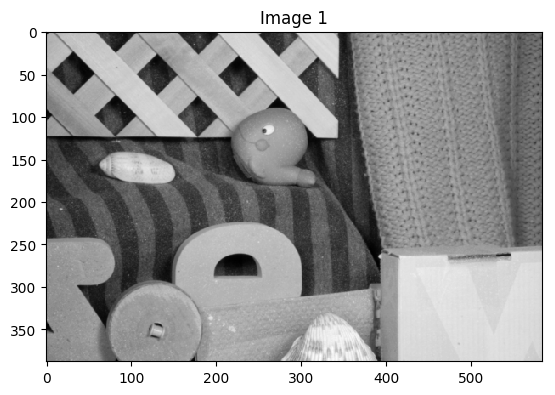

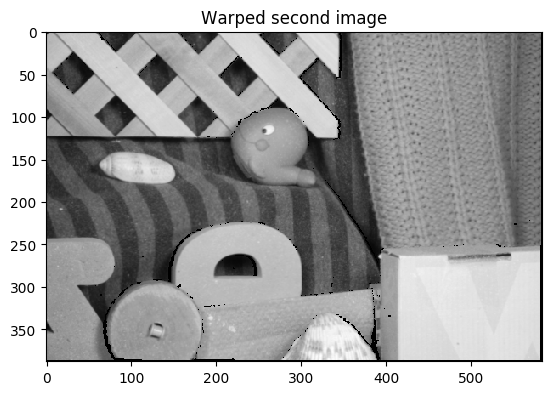

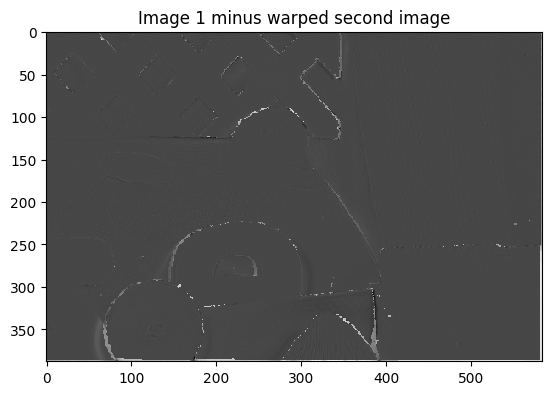

PyObject Text(0.5,1,'Image 1 minus warped second image')

In [2]:
img1=PyPlot.imread("frame10.png")   ##loading the image  

im1 = 0.2989*img1[:,:,1] + 0.5870*img1[:,:,2] + 0.1140*img1[:,:,3]  ## converting the color images in grayscale

img2=PyPlot.imread("frame11.png")   ##loading the image 

im2 = 0.2989*img2[:,:,1] + 0.5870*img2[:,:,2] + 0.1140*img2[:,:,3]  ## converting the color images in grayscale


uv_gt=read_flow_file("flow10.flo")  # flow data
sigma=1
uv0=zeros(uv_gt);


figure()
PyPlot.imshow(im1,"gray")
PyPlot.title("Image 1")

warp_img2=warp_image(im2, uv_gt)
figure()
PyPlot.imshow(warp_img2,"gray")
PyPlot.title("Warped second image")

figure()
PyPlot.imshow(im1-warp_img2,"gray")
PyPlot.title("Image 1 minus warped second image")
#the below line of code takes lot of time to run so using the best found lambda values directly
#lambdaMin=find_lambda(im1,im2,uv0,uv_gt,1.0)

AEPE for best lambda is 0.455435 
AEPE for lambda 0.0001 is 0.654061 


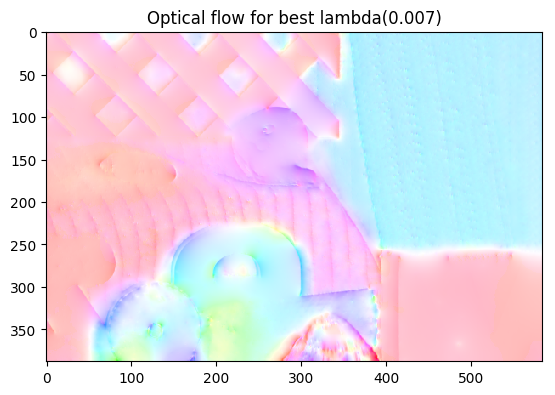

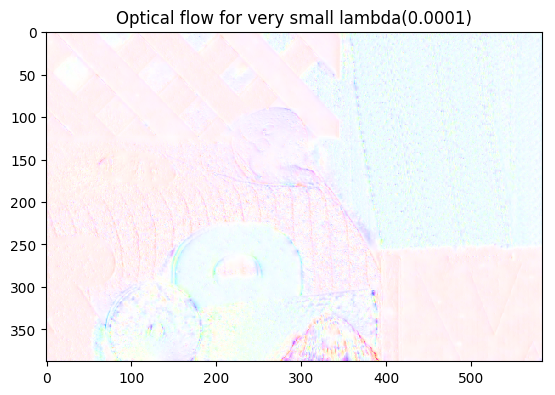

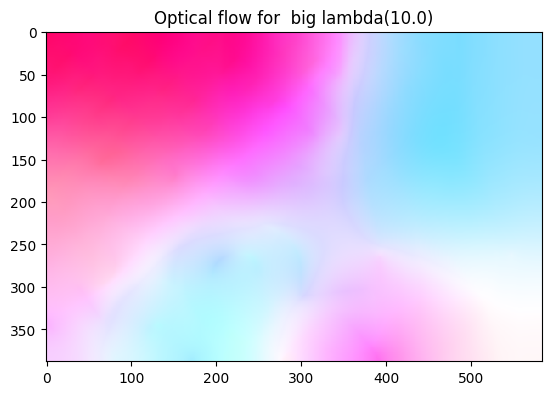

AEPE for lambda 10 is 1.019256 


In [3]:
 ## single itertion case ##
    ff=flow_HS(im1, im2,uv0,0.007, 1.0)
    figure()
    PyPlot.imshow(flow_to_color(ff))
    PyPlot.title("Optical flow for best lambda(0.007)")
    a=evaluate_flow(ff,uv_gt)
    @printf("AEPE for best lambda is %f \n", a)
    
   

   ff=flow_HS(im1, im2,uv0,0.0001, 1.0)
   figure()
    PyPlot.imshow(flow_to_color(ff))
    PyPlot.title("Optical flow for very small lambda(0.0001)")
    a=evaluate_flow(ff,uv_gt)
    @printf("AEPE for lambda 0.0001 is %f \n", a)
  

    ff=flow_HS(im1, im2,uv0,10.0, 1.0)
    figure()
    PyPlot.imshow(flow_to_color(ff))
     PyPlot.title("Optical flow for  big lambda(10.0)")
    a=evaluate_flow(ff,uv_gt)
    @printf("AEPE for lambda 10 is %f \n", a)
   
    ## single itertion case end ##   
    
 

AEPE for iteration 1 is 0.455326 
AEPE for iteration 2 is 0.306657 
AEPE for iteration 3 is 0.278348 
AEPE for iteration 4 is 0.266312 


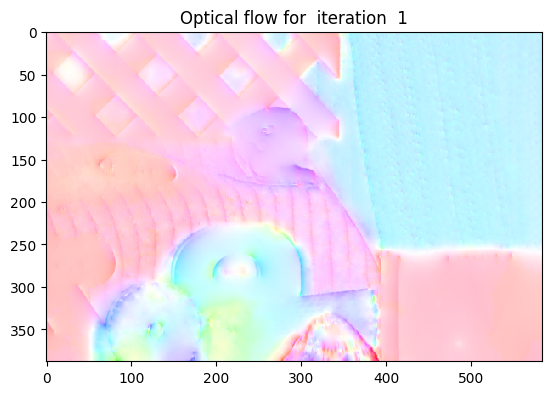

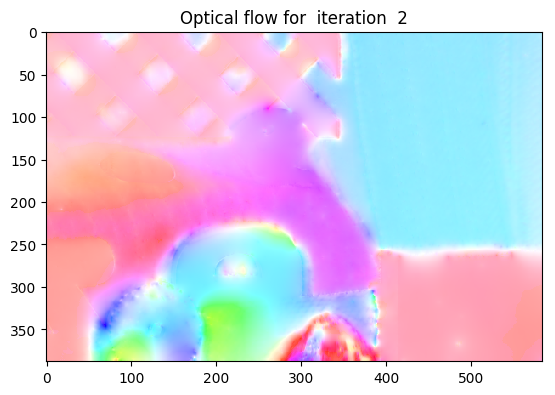

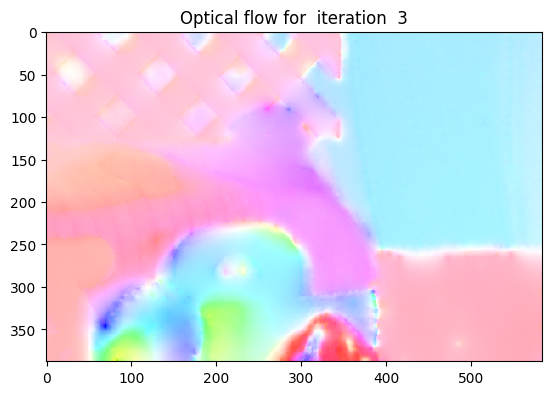

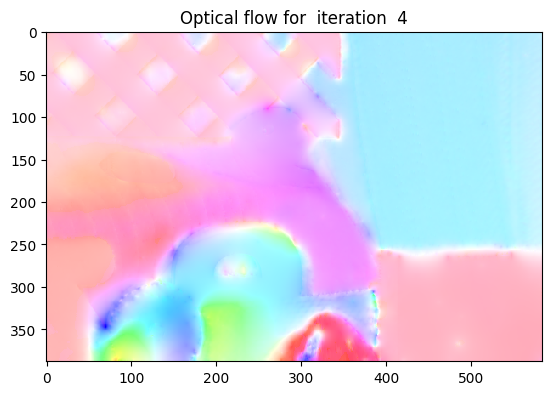

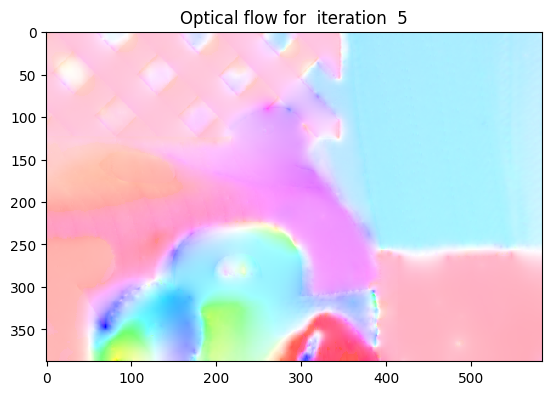

AEPE for iteration 5 is 0.258546 


In [4]:
 
   ###multi iteration case####

   
    for k=1:5
        ff=flow_HS(im1, im2,uv0,0.005, 1.0)
        uv0=ff    
         figure()
        PyPlot.imshow(flow_to_color(ff)) 
        PyPlot.title("Optical flow for  iteration  $k")
        a=evaluate_flow(ff,uv_gt)
        @printf("AEPE for iteration %d is %f \n", k,a)
       
    end
 #####multi iteration case end####    
    

